In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('C:\\Users\\Adarsh\\Downloads\\Myfiles\\archive\\asl_alphabet_test\\asl_alphabet_test'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Importing the libraries <span id="1"></span>

In [2]:
import os
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


# Checking the data folders<span id="2"></span>

#### Create the path as the variable and run a loop for all the folders. Create a dictionary of the paths with keyt as the labels and cionvert it to pandas dataframe

In [3]:
train_folder = 'C:\\Users\\91876\\Desktop\\archive\\asl_alphabet_train\\asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df


        

,label,path
0,A,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
1,A,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
2,A,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
3,A,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
4,A,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
...,...,...
86995,Z,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
86996,Z,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
86997,Z,C:\Users\91876\Desktop\archive\asl_alphabet_tr...
86998,Z,C:\Users\91876\Desktop\archive\asl_alphabet_tr...


#### Create a holdout and validation subset from the data. Holdout will be used at the end to evaluate our model. Validation will be used to find the optimum accuracy.

In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

# Image Extraction<span id="3"></span>

#### We fix the image height and width and rescale the images. "Flow_from_Dataframe"loads the image dataset in memory and generates batches of augmented data. We create such batches for trainning, validation and holdout data.

In [5]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# Model creation<span id="4"></span>

#### Using a basic convolution neural network, we create a basic model to recognise the sign language.

In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

#### Compling the model with "Adam" as the optimizer and "categorical_crossentropy" as the loss. we get around 900k parameters for the model to get trained on.

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

#### We assign an early stop when the model doesn't provide better results for 5 times continuosly. Assign the batch size as 128 and epochs as 10. Finally we fit the model and train it

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=20

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
230/230 [==============================] - 446s 2s/step - loss: 2.1384 - accuracy: 0.3584 - val_loss: 0.6115 - val_accuracy: 0.7950
Epoch 2/20
230/230 [==============================] - 440s 2s/step - loss: 0.3986 - accuracy: 0.8615 - val_loss: 0.1409 - val_accuracy: 0.9551
Epoch 3/20
230/230 [==============================] - 665s 3s/step - loss: 0.1722 - accuracy: 0.9404 - val_loss: 0.0558 - val_accuracy: 0.9829
Epoch 4/20
230/230 [==============================] - 376s 2s/step - loss: 0.0995 - accuracy: 0.9664 - val_loss: 0.0350 - val_accuracy: 0.9898
Epoch 5/20
230/230 [==============================] - 377s 2s/step - loss: 0.0586 - accuracy: 0.9804 - val_loss: 0.0265 - val_accuracy: 0.9918
Epoch 6/20
230/230 [==============================] - 365s 2s/step - loss: 0.0545 - accuracy: 0.9820 - val_loss: 0.0137 - val_accuracy: 0.9963
Epoch 7/20
230/230 [==============================] - 363s 2s/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0112 - val_accuracy: 0.9964

# Validation and Training accuracy plot<span id="5"></span>

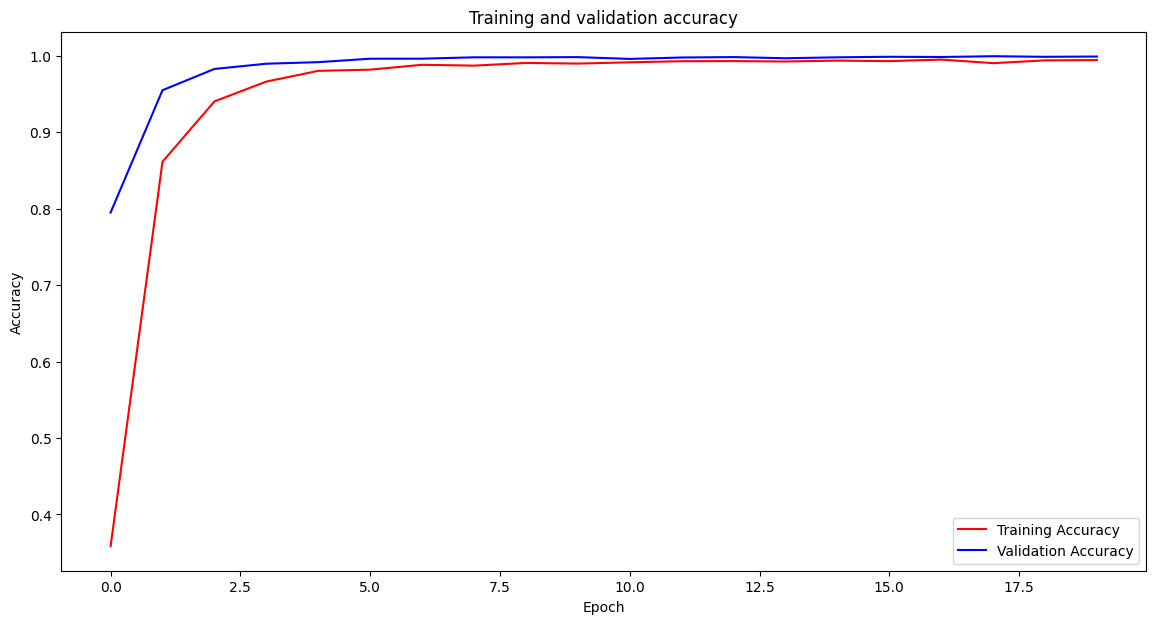

In [9]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

# Validation and Training loss plot<span id="6"></span>

Text(0.5, 1.0, 'Training and validation loss')

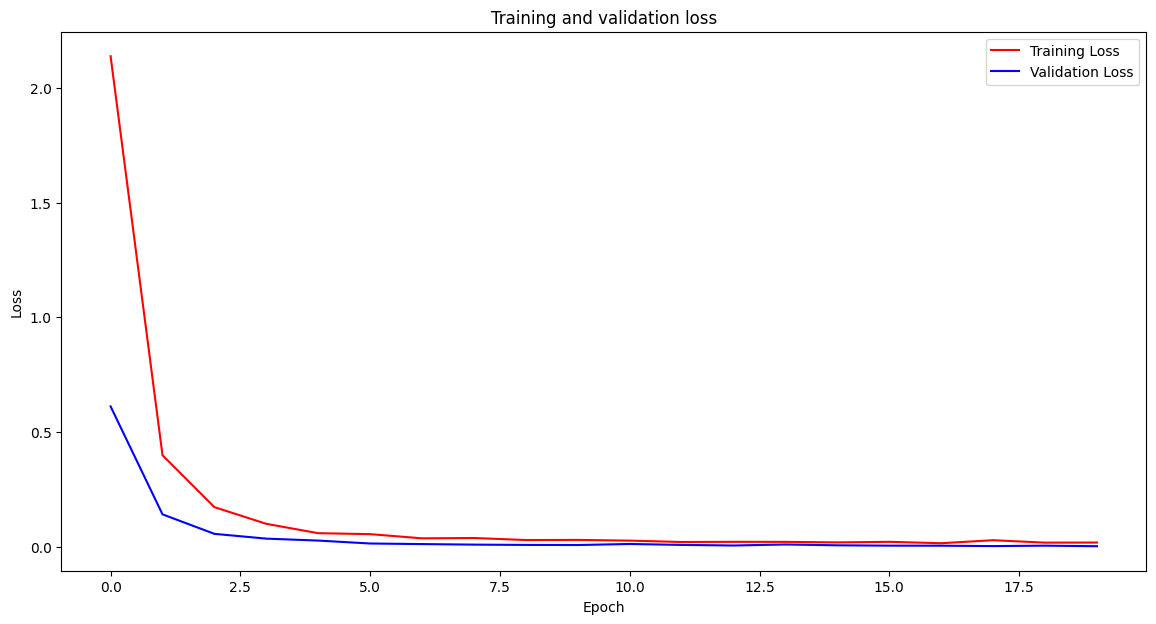

In [10]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

# Prediction<span id="7"></span>

#### Finally predicting and checking the accuracy from the holdout data.

In [11]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

34/34 [==============================] - 16s 445ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       300
           B       1.00      1.00      1.00       300
           C       1.00      1.00      1.00       300
           D       1.00      1.00      1.00       300
           E       1.00      0.99      1.00       300
           F       1.00      1.00      1.00       300
           G       1.00      1.00      1.00       300
           H       1.00      1.00      1.00       300
           I       1.00      1.00      1.00       300
           J       1.00      1.00      1.00       300
           K       1.00      1.00      1.00       300
           L       1.00      1.00      1.00       300
           M       1.00      1.00      1.00       300
           N       1.00      1.00      1.00       300
           O       1.00      1.00      1.00       300
           P       1.00      1.00      1.00       300
           Q       1.00  

#### Creating a visual to see if there are any misclassifications

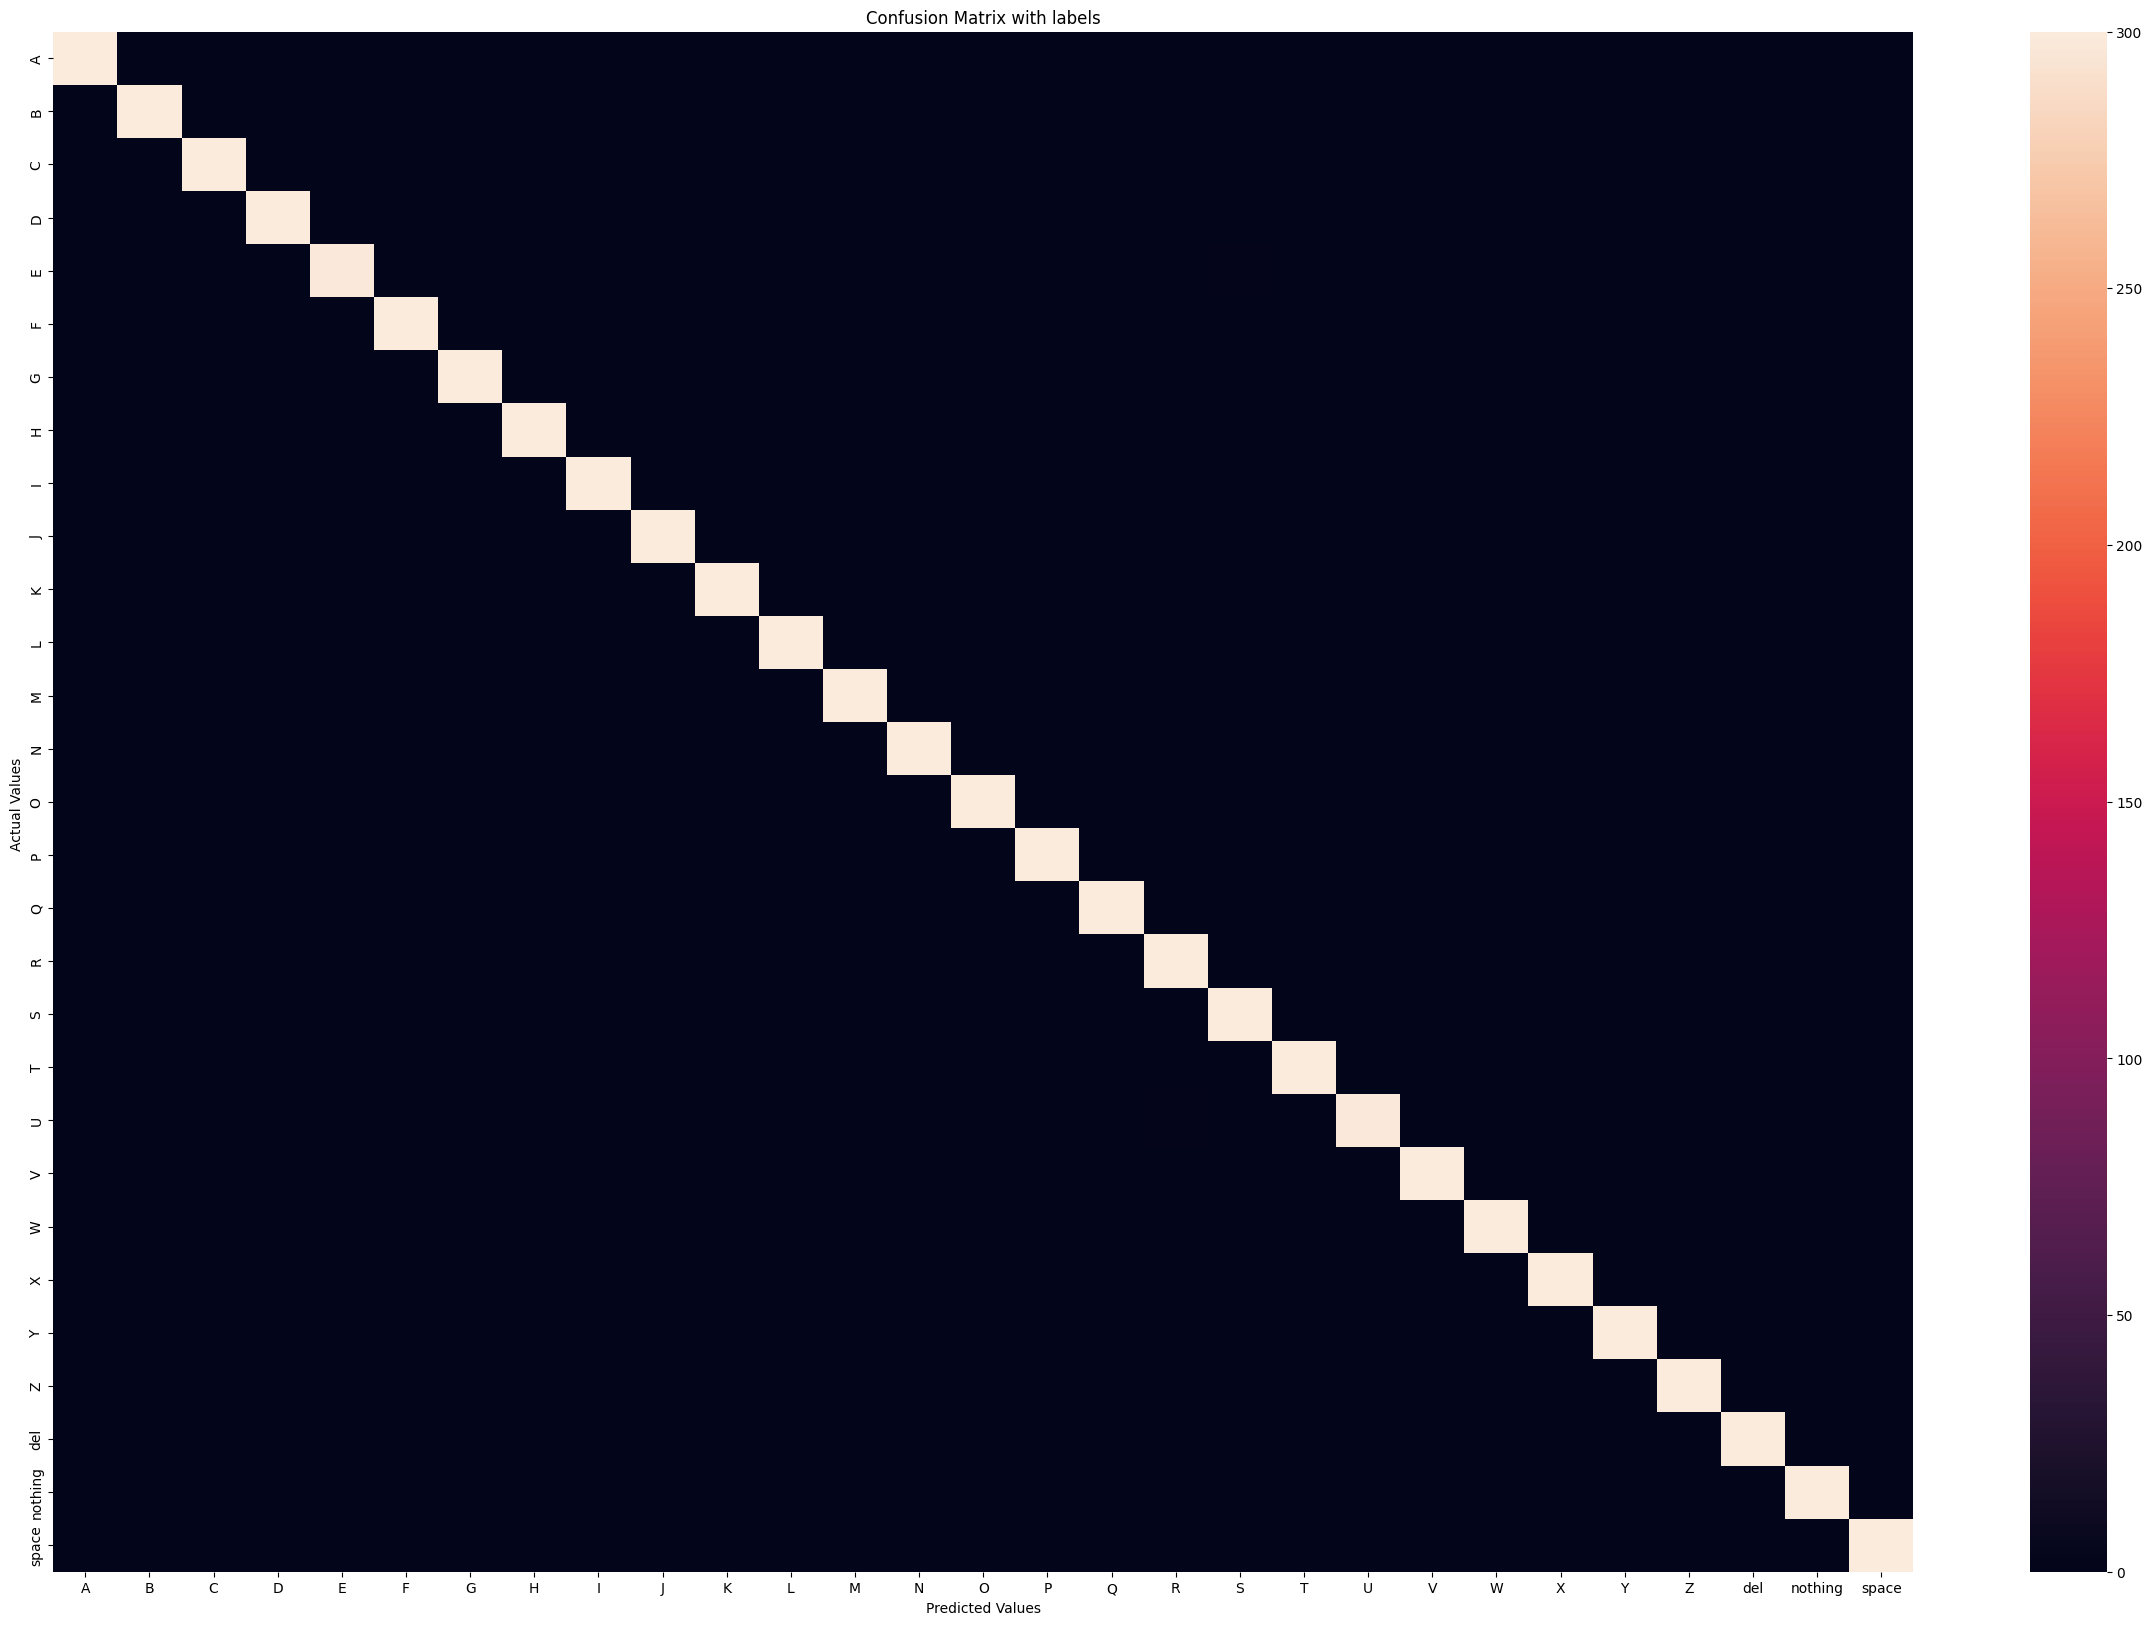

In [12]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

# Conclusion<span id="7"></span>

#### We almost get 99% accuracy on the model. This is partly due to the highly accurate and clear data set that we have. There was not a high variation and the hands/fingers were clearly detected by the model. This resulted in very high accuracy from a fairly simple model. This shows how important the data centric approach is and why we should focus a lot in the clarity of the data.

In [15]:
model.save('ASL_classification.h5')